# Data Scientist Professional Case Study

### Company Background

Snow Cone Games are a digital retailer for video games. The website includes a simple filter for the genre of the game as well as more advanced filtering. The product manager has recently learned that only 23% of buyers search for games using the genre filter. 

71% of buyers use advanced filters to find the types of games that appeal to them. The product manager hopes that new categories based on different game attributes can help players find what they are looking for faster.


### Customer Question

The product manager would like to know:
- Can you use the data from 40,000 games to identify groupings of games that are most similar to each other?


### Success Criteria

Ideally, there would be no more than five groupings. Any more would make it much harder to display on the page so there would need to be a good reason to have more.


### Dataset

The data you will use for this analysis can be accessed here: `"data/video_games.csv"`

In [1]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!


In [2]:
#import packages, load data, check for number of rows

import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy import stats, special
from scipy.cluster.hierarchy import dendrogram, linkage
from seaborn import pairplot, heatmap
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,10)})
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
np.random.seed(1)


df = pd.read_csv("data/video_games.csv", header = 0).drop_duplicates(keep='first') #only keep first record of duplicate

df.info()#display data type, number of columns, number of rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40819 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              40815 non-null  object 
 1   release_date      37653 non-null  object 
 2   developer         40488 non-null  object 
 3   achievements      12193 non-null  float64
 4   original_price    35521 non-null  object 
 5   percent_positive  17362 non-null  object 
 6   num_reviews       17362 non-null  float64
 7   multiplayer       40309 non-null  object 
 8   mature            40819 non-null  bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 2.8+ MB


In [3]:
#Check for number of dupliactes, In case of 'name' column these records will need to be reviewed and dropped. 
clmn = df.columns
i=0
while i < len(df.columns):
	print('column',clmn[i],'contains',df[clmn[i]].duplicated().sum(), 'duplicates')
	i+=1

print('And there are',df.duplicated().sum(),'duplicated rows of data')

column name contains 69 duplicates
column release_date contains 36711 duplicates
column developer contains 23398 duplicates
column achievements contains 40458 duplicates
column original_price contains 40137 duplicates
column percent_positive contains 40718 duplicates
column num_reviews contains 38051 duplicates
column multiplayer contains 40816 duplicates
column mature contains 40817 duplicates
And there are 0 duplicated rows of data


In [4]:
#Review duplicated rows by name, release date, and developer, and sort. Review visually because it is only 29 rows.
df[df[['name','release_date']].duplicated(keep = False)].sort_values(by=['name','num_reviews','original_price','developer',])

#Dropping Index # 704, 4847, 31321 since most of data is NULL, including name
df.drop(index = [704,4827,31321], inplace = True)

In [5]:
#Sorting duplicated based on the amount of most usefult information(based on my opinion), only keeping the first index :
df[df[['name','release_date']].duplicated(keep = False)].sort_values(by=['name','num_reviews','original_price','developer',])

dups = df[df[['name','release_date']].duplicated(keep = False)].sort_values(by=['name','num_reviews','original_price','developer',])

names = dups['name'].unique()

index_delete = []

for i in names:
    index_capture = []
    index_capture.append(dups[dups['name']==i].index)
    n=1
    while n < len(index_capture[0]):
        index_delete.append(index_capture[0][n])
        n+=1
print(index_delete)
df.drop(index = index_delete, inplace = True)


[19725, 7402, 23089, 29480, 20469, 12867, 12884, 12141, 6848, 23468, 23408, 7762, 9955, 28167, 5410]


In [6]:
# Identify the percentage of null data in every column. Achievements, percent positive, num_reviews have NULL values in over 50% of rows.

df.isnull().sum()/len(df)*100

name                 0.004902
release_date         7.717948
developer            0.806353
achievements        70.118379
original_price      12.953114
percent_positive    57.449572
num_reviews         57.449572
multiplayer          1.247518
mature               0.000000
dtype: float64

In [7]:
#Replacing NULL values with zeros in Achievements, num_reviews -- it is safe to assume that NULLs are 0s for these variables.
df['achievements'].fillna(0, inplace = True)
df['num_reviews'].fillna(0, inplace = True)
df.isnull().sum()/len(df)*100


name                 0.004902
release_date         7.717948
developer            0.806353
achievements         0.000000
original_price      12.953114
percent_positive    57.449572
num_reviews          0.000000
multiplayer          1.247518
mature               0.000000
dtype: float64

In [8]:
#Reviewing amount of rows with fully completed data

print('Only',len(df.dropna(how='any'))/(len(df))*100,'percent of rows are properly filled out with with no missing values in columns. Which equals to', len(df.dropna(how='any')), 'rows')


Only 40.85929266439548 percent of rows are properly filled out with with no missing values in columns. Which equals to 16671 rows


In [9]:
# Dropping all rows with and missing data. This will be a perfectly clean dataset. 16671 clean rows of data should be enough for k-means (unssupervised clustering)

df_clean = df.dropna(how='any')

#Change True and False variables to 1 and 0
df_clean['multiplayer'].replace(to_replace = False, value=0, inplace = True, regex = True)
df_clean['multiplayer'].replace(to_replace = True, value=1, inplace = True, regex = True)
df_clean['mature'].replace(to_replace = False, value = 0, inplace = True, regex = True)
df_clean['mature'].replace(to_replace = True, value = 1, inplace = True, regex = True)

#Change percent_positive to decimal
df_clean['percent_positive']= df_clean['percent_positive'].str.strip('%').astype(float)/100



#Remove dollar sign from ['original_price']
df_clean['original_price'] = df_clean['original_price'].str.strip('$')

#Change free games to value 0 in 'original_price'
df_clean['original_price'][df_clean['original_price'].str.contains('Free', case = False)] = '0'
#Drop all non-numeric values (most of which are demos)

df_clean['original_price'] = np.where((df_clean['original_price'].str.contains('[0-9]')
                                       & ~df_clean['original_price'].str.contains('[A-Z]')) == True,
                                        df_clean['original_price'], np.nan)
df_clean = df_clean.dropna(how='any')

#change data value to numeric
df_clean['original_price']=df_clean['original_price'].astype(float)


#Create new column #Positive_review_count by multiplying percent positive reviews with numer of reviews
df_clean.insert(6,'positive_review_count','')
df_clean['positive_review_count'] = df_clean['percent_positive'].astype(float)
df_clean['positive_review_count'] = df_clean['positive_review_count']*df_clean['num_reviews']
df_clean['positive_review_count'] = df_clean['positive_review_count'].astype(int).round(decimals = 0)

df_clean

,name,release_date,developer,achievements,original_price,percent_positive,positive_review_count,num_reviews,multiplayer,mature
0,DOOM,"May 12, 2016",id Software,54.0,19.99,0.92,39146,42550.0,1,0
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,29.99,0.49,409937,836608.0,1,1
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,39.99,0.71,4991,7030.0,1,0
3,DayZ,"Dec 13, 2018",Bohemia Interactive,0.0,44.99,0.61,101940,167115.0,1,0
4,EVE Online,"May 6, 2003",CCP,0.0,0.00,0.74,8495,11481.0,1,0
...,...,...,...,...,...,...,...,...,...,...
40524,Lil Big Invasion,"Aug 4, 2016",Andreas Britten,45.0,2.99,1.00,13,13.0,0,0
40598,Detached: Non-VR Edition,"Jul 24, 2018",Anshar Studios,47.0,14.99,0.78,10,14.0,1,0
40611,A Room Beyond,"Jun 13, 2017",René Bühling,44.0,7.99,0.90,9,11.0,0,0
40728,Chasing the Stars,"Jan 23, 2019",Ertal Games,12.0,9.99,0.70,7,10.0,0,1


<AxesSubplot:>

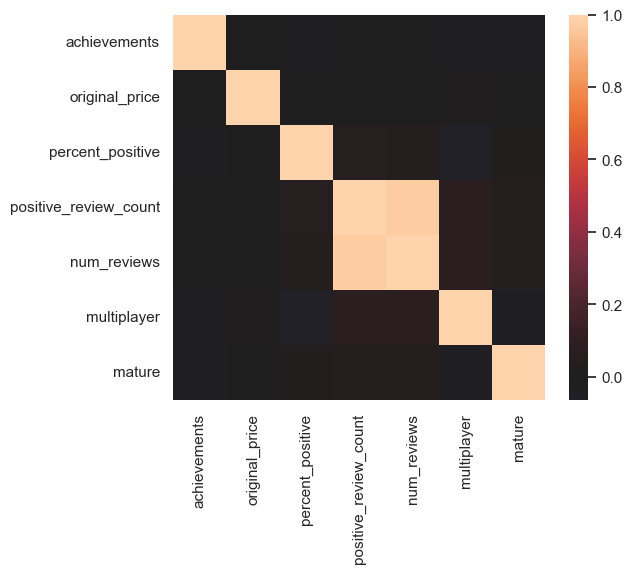

In [10]:
#Plotting a correlation matrix to spot any 'viewable' relationships between variables.
plt.figure(figsize=(6,5))
sns.heatmap(df_clean.corr(), center = 0)

#Only positive correlation can be seen in the created 'positive_review_count' column, which could mean the game is just more popular. So num_review is good indicator of positive reviews, but also an indicator of game's popularity.

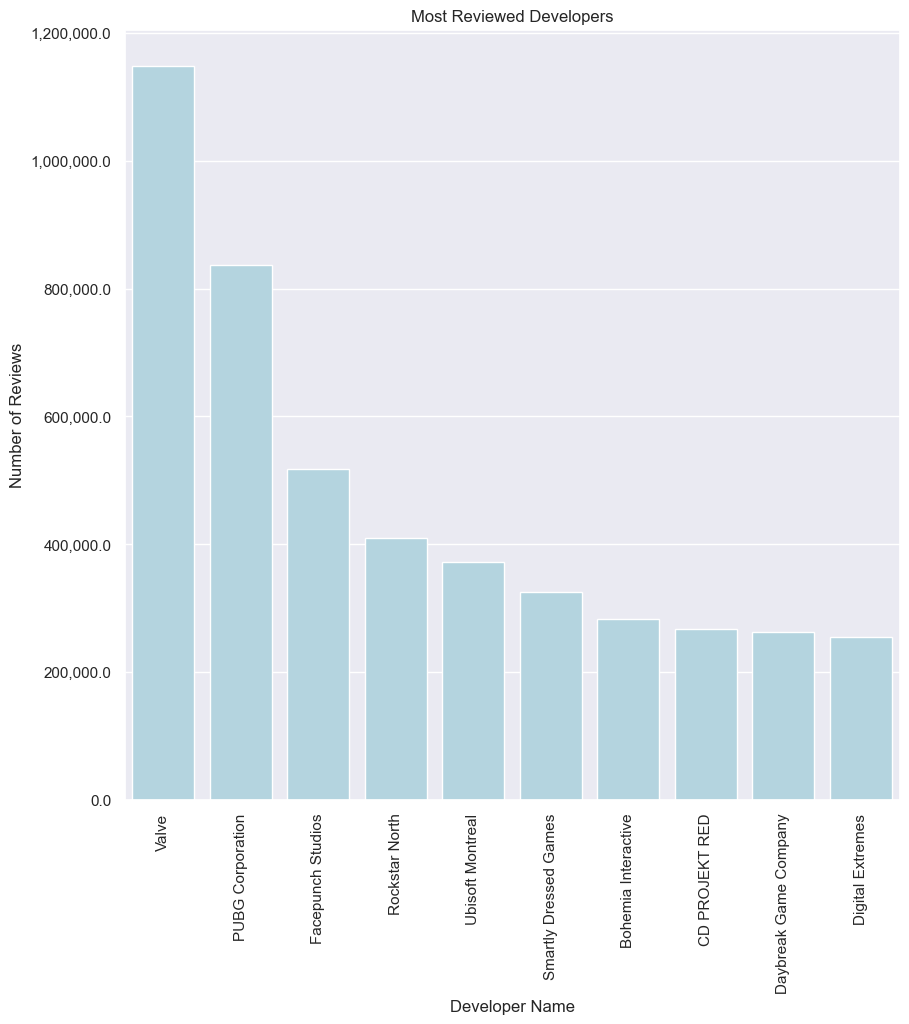

In [11]:
#Display most popular developers
agg_developer = df_clean.groupby('developer').agg('sum')#Group by developer
agg_developer = agg_developer.sort_values(['num_reviews'], ascending = False)#sort by number of reviews
agg_developer['percent_positive'] = agg_developer['positive_review_count']/agg_developer['num_reviews']*100
agg_developer.reset_index(inplace=True)
popular_developer = agg_developer.head(10)#Show top 10 popular_developers
#Plot Amount of reviews and percent of positive reviews for developers
ax = sns.barplot(x = 'developer',y='num_reviews', data = popular_developer, color = 'lightblue')
ax.set_xlabel('Developer Name')
ax.set_ylabel('Number of Reviews')
ax.set_title('Most Reviewed Developers')
ax.tick_params(axis='x',rotation=90)#rotate labels for x axis
plt.ticklabel_format(style='plain', axis='y',useOffset=False)#remove scientific notation on y axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))#add comas to values over 1000
plt.show()

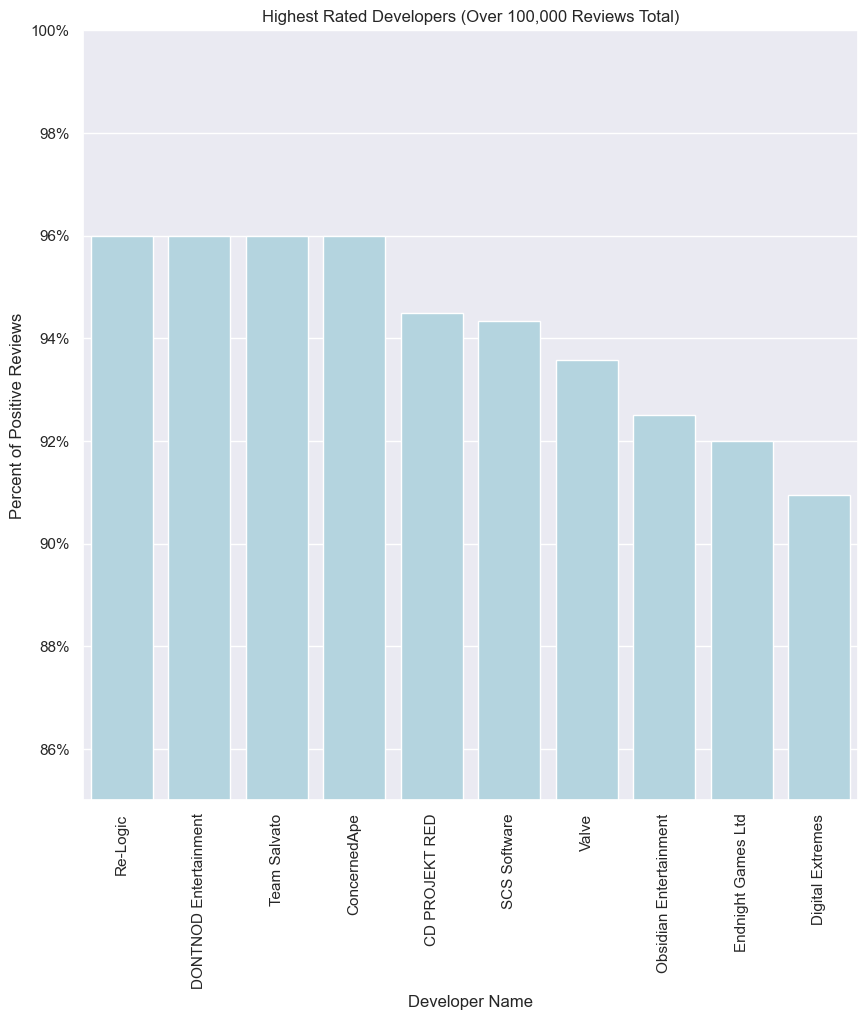

In [12]:
#Highest Rated Develoer with over 100,000 reviews total
agg_developer = agg_developer[agg_developer['num_reviews']>100000].sort_values(['percent_positive'], ascending = False)
agg_developer.replace(to_replace= 'DONTNOD Entertainment,Feral Interactive (Mac),Feral Interactive (Linux)',value='DONTNOD Entertainment', inplace = True)#Replace comapny's name -- to long
highest_rated_dev = agg_developer.head(10)

ax = sns.barplot(x = 'developer',y=highest_rated_dev['percent_positive']/100, data = highest_rated_dev, color = 'lightblue')
ax.set_xlabel('Developer Name')
ax.set_ylabel('Percent of Positive Reviews')
ax.set_title('Highest Rated Developers (Over 100,000 Reviews Total)')
ax.tick_params(axis='x',rotation=90)#rotate labels for x axis
plt.ylim(.85, 1)# Reduce y-axis range to improve 
plt.ticklabel_format(style='plain', axis='y',useOffset=False)#remove scientific notation on y axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))#add comas to values over 1000

plt.show()

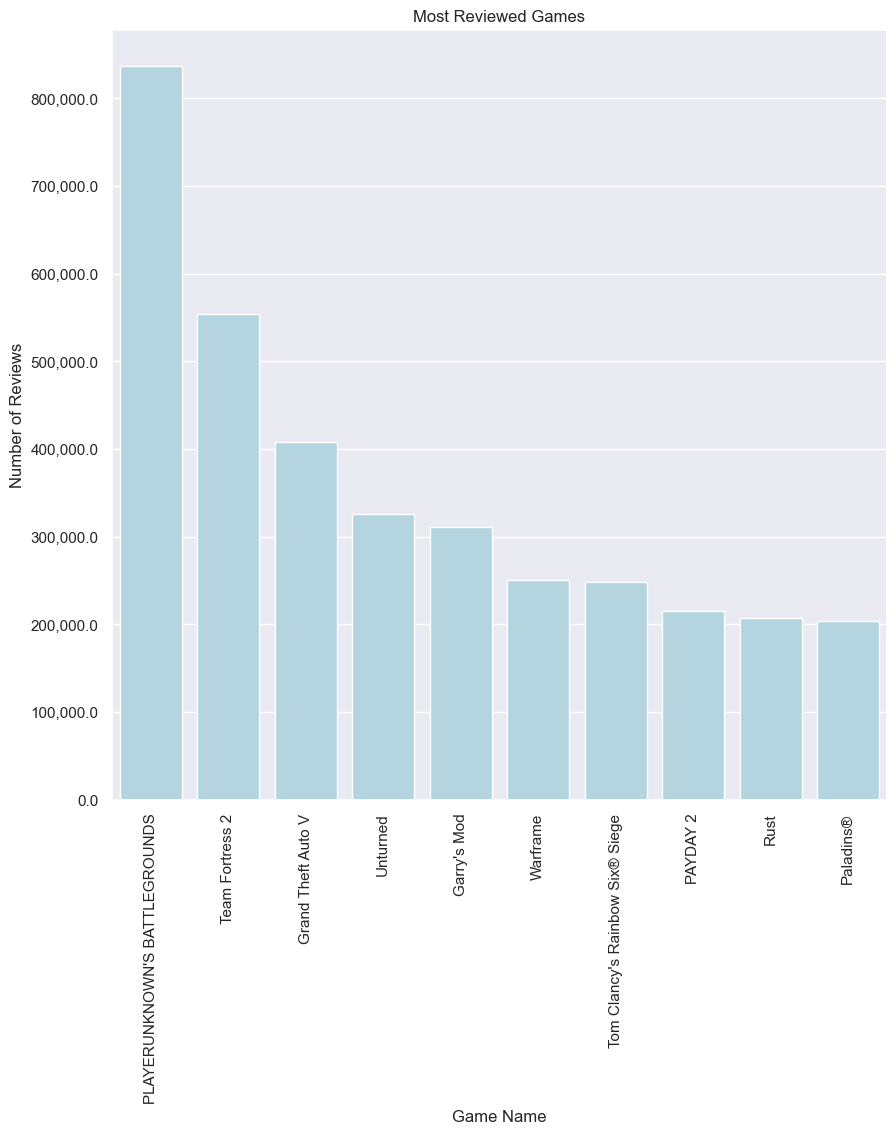

In [13]:
#Display most popular games
agg_game = df_clean.groupby('name').agg('sum')#Group by developer
agg_game = agg_game.sort_values(['num_reviews'], ascending = False)#sort by number of reviews
agg_game['percent_positive'] = agg_game['positive_review_count']/agg_game['num_reviews']*100
agg_game.reset_index(inplace=True)
popular_game = agg_game.head(10)#Show top 10 popular_developers

#Plot Amount of reviews for games
ax = sns.barplot(x = 'name',y='num_reviews', data = popular_game, color = 'lightblue')
ax.set_xlabel('Game Name')
ax.set_ylabel('Number of Reviews')
ax.set_title('Most Reviewed Games')
ax.tick_params(axis='x',rotation=90)#rotate labels for x axis
plt.ticklabel_format(style='plain', axis='y',useOffset=False)#remove scientific notation on y axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))#add comas to values over 1000
plt.show()

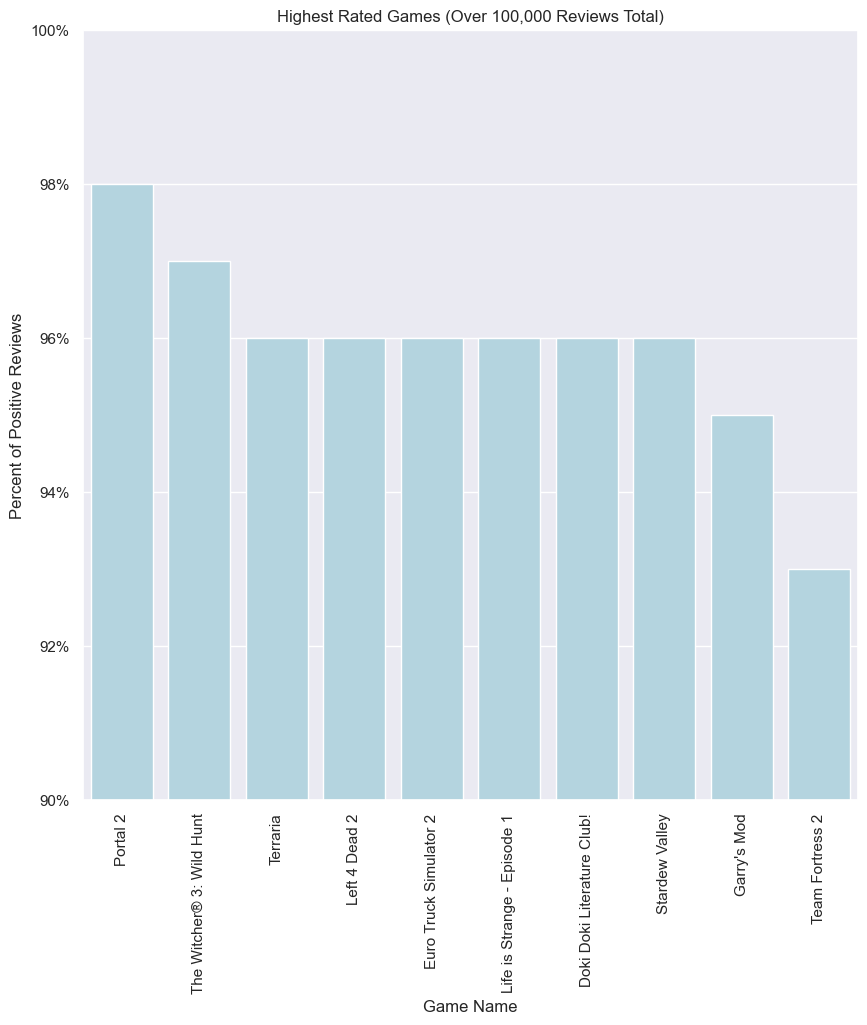

In [14]:
#Highest Rated games with over 100,000 reviews total
agg_game = agg_game[agg_game['num_reviews']>100000].sort_values(['percent_positive'], ascending = False)

highest_rated_game = agg_game.head(10)

ax = sns.barplot(x = 'name',y=highest_rated_game['percent_positive']/100, data = highest_rated_game, color = 'lightblue')
ax.set_xlabel('Game Name')
ax.set_ylabel('Percent of Positive Reviews')
ax.set_title('Highest Rated Games (Over 100,000 Reviews Total)')
ax.tick_params(axis='x',rotation=90)#rotate labels for x axis
plt.ylim(.90, 1)# Reduce y-axis range to improve 
plt.ticklabel_format(style='plain', axis='y',useOffset=False)#remove scientific notation on y axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))#add Percent sign

plt.show()

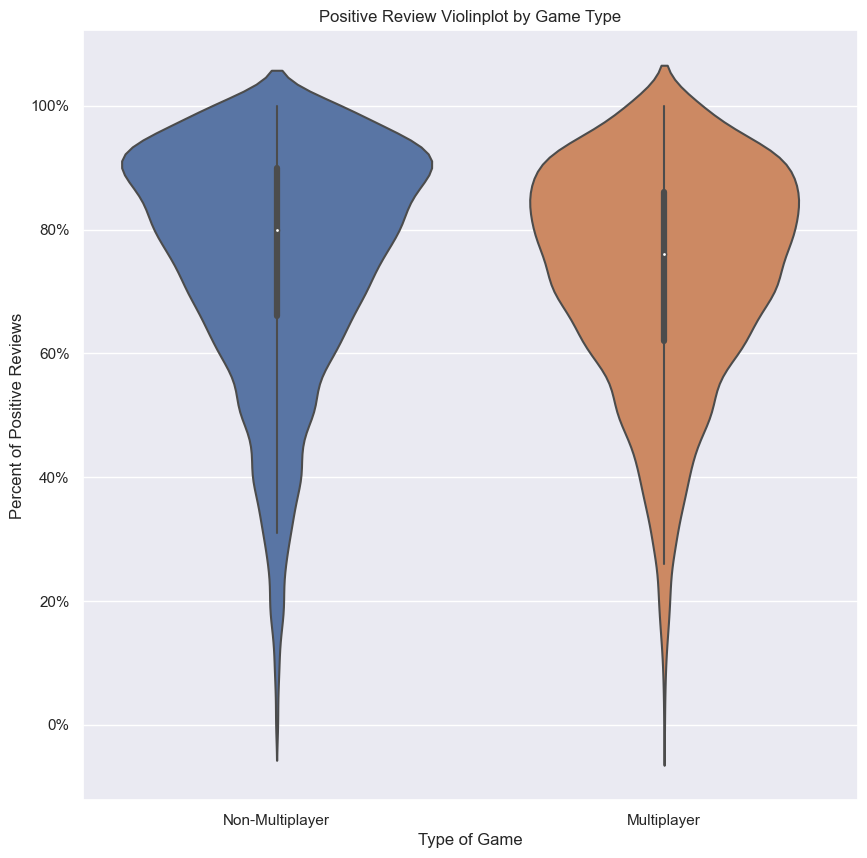

In [15]:
#Violin Plot to identify distribution difference between multiplayer games and percent % reviews. Scatter plot didn't wortk out too well, too much data scatter accross the axis.
ax =sns.violinplot(x='multiplayer', y= 'percent_positive', data = df_clean, inner = 'box')
ax.set_xlabel('Type of Game')
ax.set_ylabel('Percent of Positive Reviews')
ax.set_title('Positive Review Violinplot by Game Type')
ax.set_xticklabels(['Non-Multiplayer', "Multiplayer"])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))#add Percent sign
#Looks like non multiplayer games tend to have higher ratings, possibly due to online toxic playes (personal experience ;P)

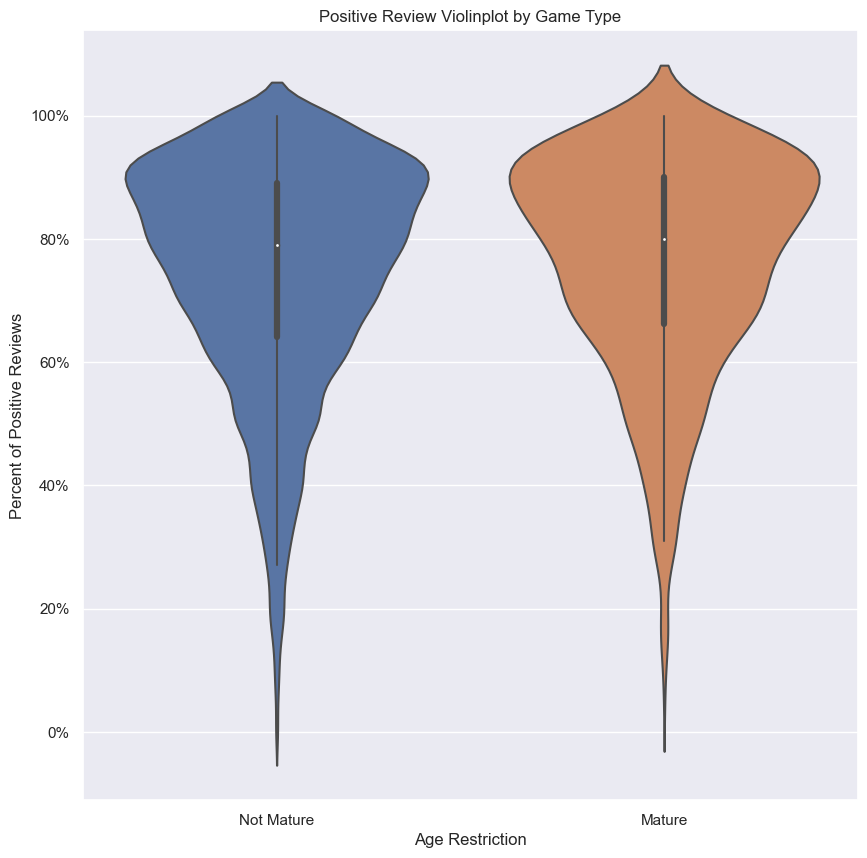

In [16]:
#Violin Plot to identify distribution difference between mature games and percent % reviews. 
ax =sns.violinplot(x='mature', y= 'percent_positive', data = df_clean, inner = 'box')
ax.set_xlabel('Age Restriction')
ax.set_ylabel('Percent of Positive Reviews')
ax.set_title('Positive Review Violinplot by Game Type')
ax.set_xticklabels(['Not Mature', "Mature"])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))#add Percent sign
#Age restriction seems to have the same distribution of positive reviews

<AxesSubplot:xlabel='achievements', ylabel='percent_positive'>

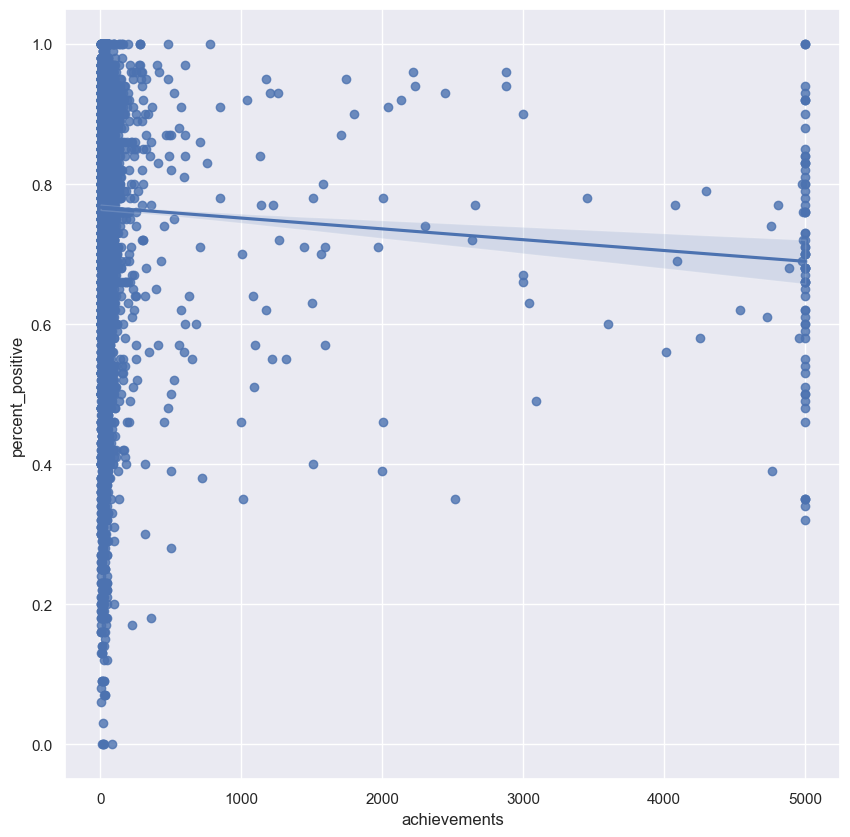

In [17]:
#Trying to look at the relationship between thr number of achievements and percent of positive reviews. Not a good quality insight, but looks like a slight negative raltionship.

temp =df_clean[(df_clean['achievements']<6000) & (df_clean['achievements']>1)]

sns.regplot(x = 'achievements'  , y = 'percent_positive' , data = temp)

In [18]:
#We are trying to segment data without labels. Therefore, we will be utilizing an unsupervised machine learning technique - K-means. It will be combine with the PCA method to improve the data. Two models will be compared, one using MinMaxScaler, the other using StandarDscaler.


#preparing data for the model:
columns = ['achievements','original_price','percent_positive','num_reviews','multiplayer','mature']
df_clean_kmeans = df_clean[columns]

#1st model - StandardScaler -> PCA -> K-means
scaler = StandardScaler()
df_clean_kmeans_ss = scaler.fit_transform(df_clean_kmeans)
#Initiate/fit PCA
pca = PCA()
pca.fit(df_clean_kmeans_ss)
#Optimize PCA by visually inspecting number of componenets and cumulative explained variance.
pca.explained_variance_ratio_



array([0.18227054, 0.1799665 , 0.1677568 , 0.1668011 , 0.16182533,
       0.14137973])

Text(0, 0.5, 'Cumulative Explained Variance')

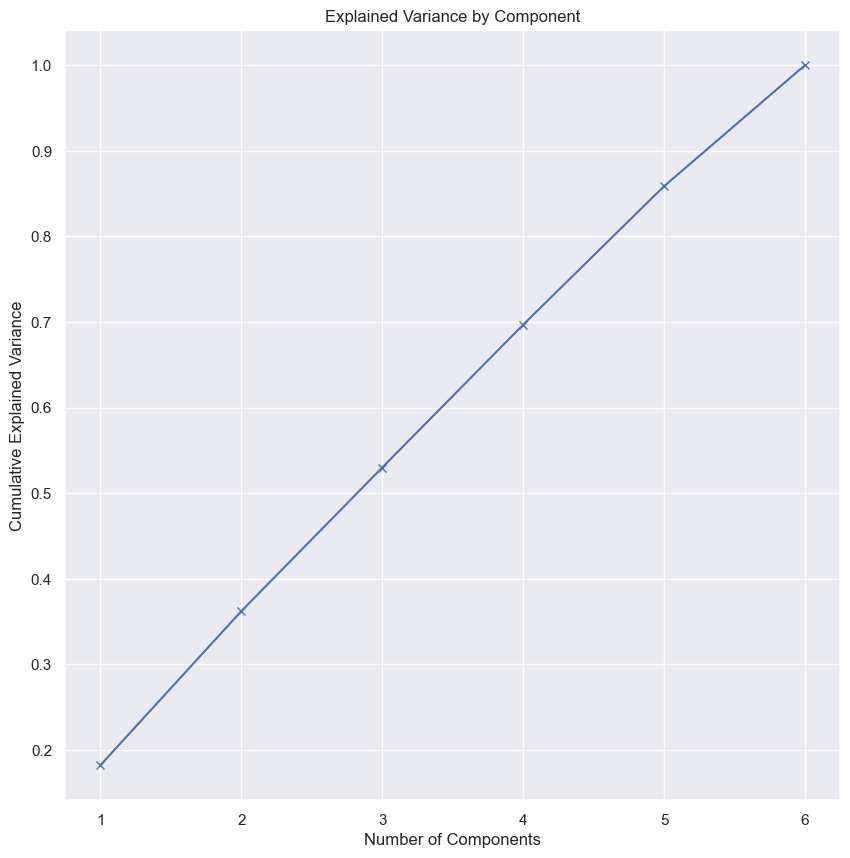

In [19]:
#Create plot for Cumulative Explained Variance
ax =plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_.cumsum(), marker = 'x')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

#GOing to keep 5 components, following the general rule of keeping around 80% variance, 6th component will overfit the model.

In [20]:
#Now that PCA is 'optimized, next is to identify N_clusters for K-means using Witihin CLuster Sum of Squares
pca = PCA(n_components=5)
df_clean_kmeans_ss = pca.fit_transform(df_clean_kmeans_ss)
df_clean_kmeans_ss
wcss = []
for i in range (1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 1)
    kmeans.fit(df_clean_kmeans_ss)
    wcss.append(kmeans.inertia_)

([<matplotlib.axis.XTick at 0x7f546d8d8190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

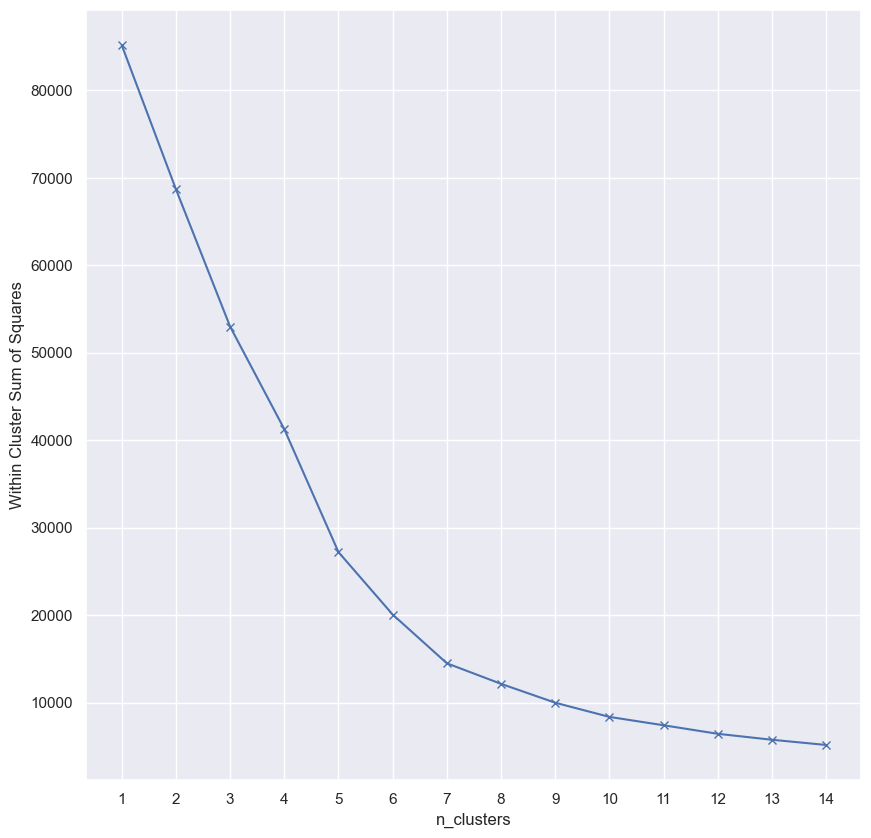

In [21]:
#Create a plot, looking for the 'elbow' effect to identify the best value for n_clusters
plt.plot(range(1,15), wcss, marker = 'x')
plt.xlabel('n_clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(1,15,1))
#7 seems to be the magic number (right at the elbow), but because of constraints in the problem, 5 n_lusters seems to be reasonable as well. Going to try both.


In [22]:
#7 n_cluster model with StdandardScaler and PCA
kmeans_n7_SS = KMeans(n_clusters = 7, init = 'k-means++', random_state = 1)#model with the elbow rule
kmeans_n5_SS = KMeans(n_clusters = 5, init = 'k-means++', random_state = 1)#model with problem limitation (only 5 clusters allowed)
kmeans_n7_SS.fit(df_clean_kmeans_ss)
kmeans_n5_SS.fit(df_clean_kmeans_ss)

KMeans(n_clusters=5, random_state=1)

<AxesSubplot:xlabel='PCA Comp 1', ylabel='PCA Comp 2'>

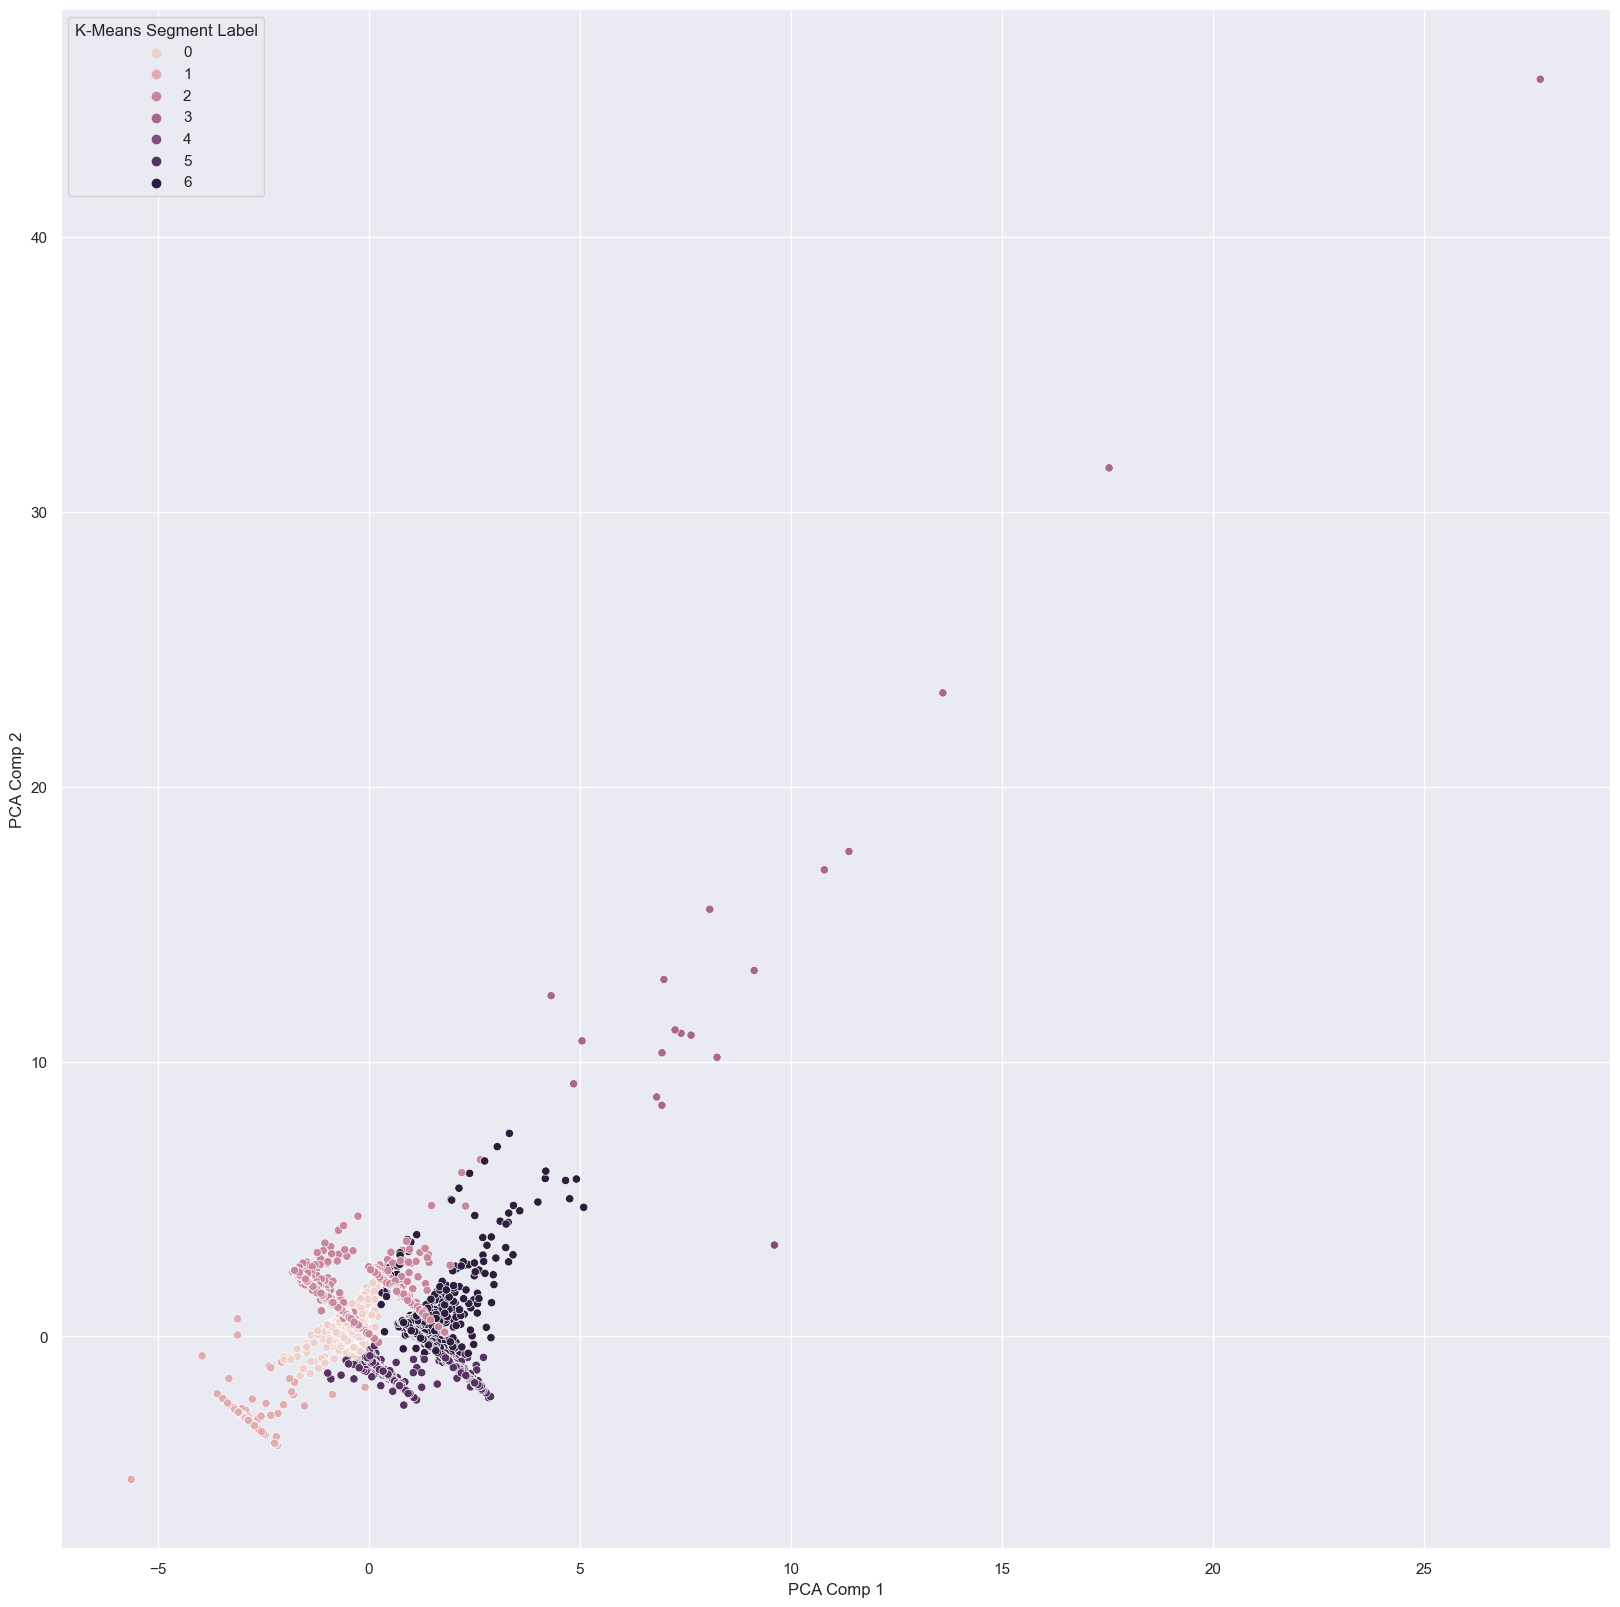

In [23]:
#Create new data frames with PCA components and cluster segment results, then plot first two components on scatterplot.
df_kmeans_n7_SS = pd.concat([df_clean.reset_index(drop=True),pd.DataFrame(df_clean_kmeans_ss)],axis=1)
df_kmeans_n7_SS.columns.values[-5:] = ['PCA Comp 1','PCA Comp 2','PCA Comp 3','PCA Comp 4','PCA Comp 5',]
df_kmeans_n7_SS['K-Means Segment Label'] = kmeans_n7_SS.labels_
sns.set(rc={'figure.figsize':(20,20)})
scatter_df_kmeans_n7_SS = sns.scatterplot(x = df_kmeans_n7_SS['PCA Comp 1'], y = df_kmeans_n7_SS['PCA Comp 2'], 
                          hue = df_kmeans_n7_SS['K-Means Segment Label'])
scatter_df_kmeans_n7_SS
#doesn't look too bad

<AxesSubplot:xlabel='PCA Comp 1', ylabel='PCA Comp 2'>

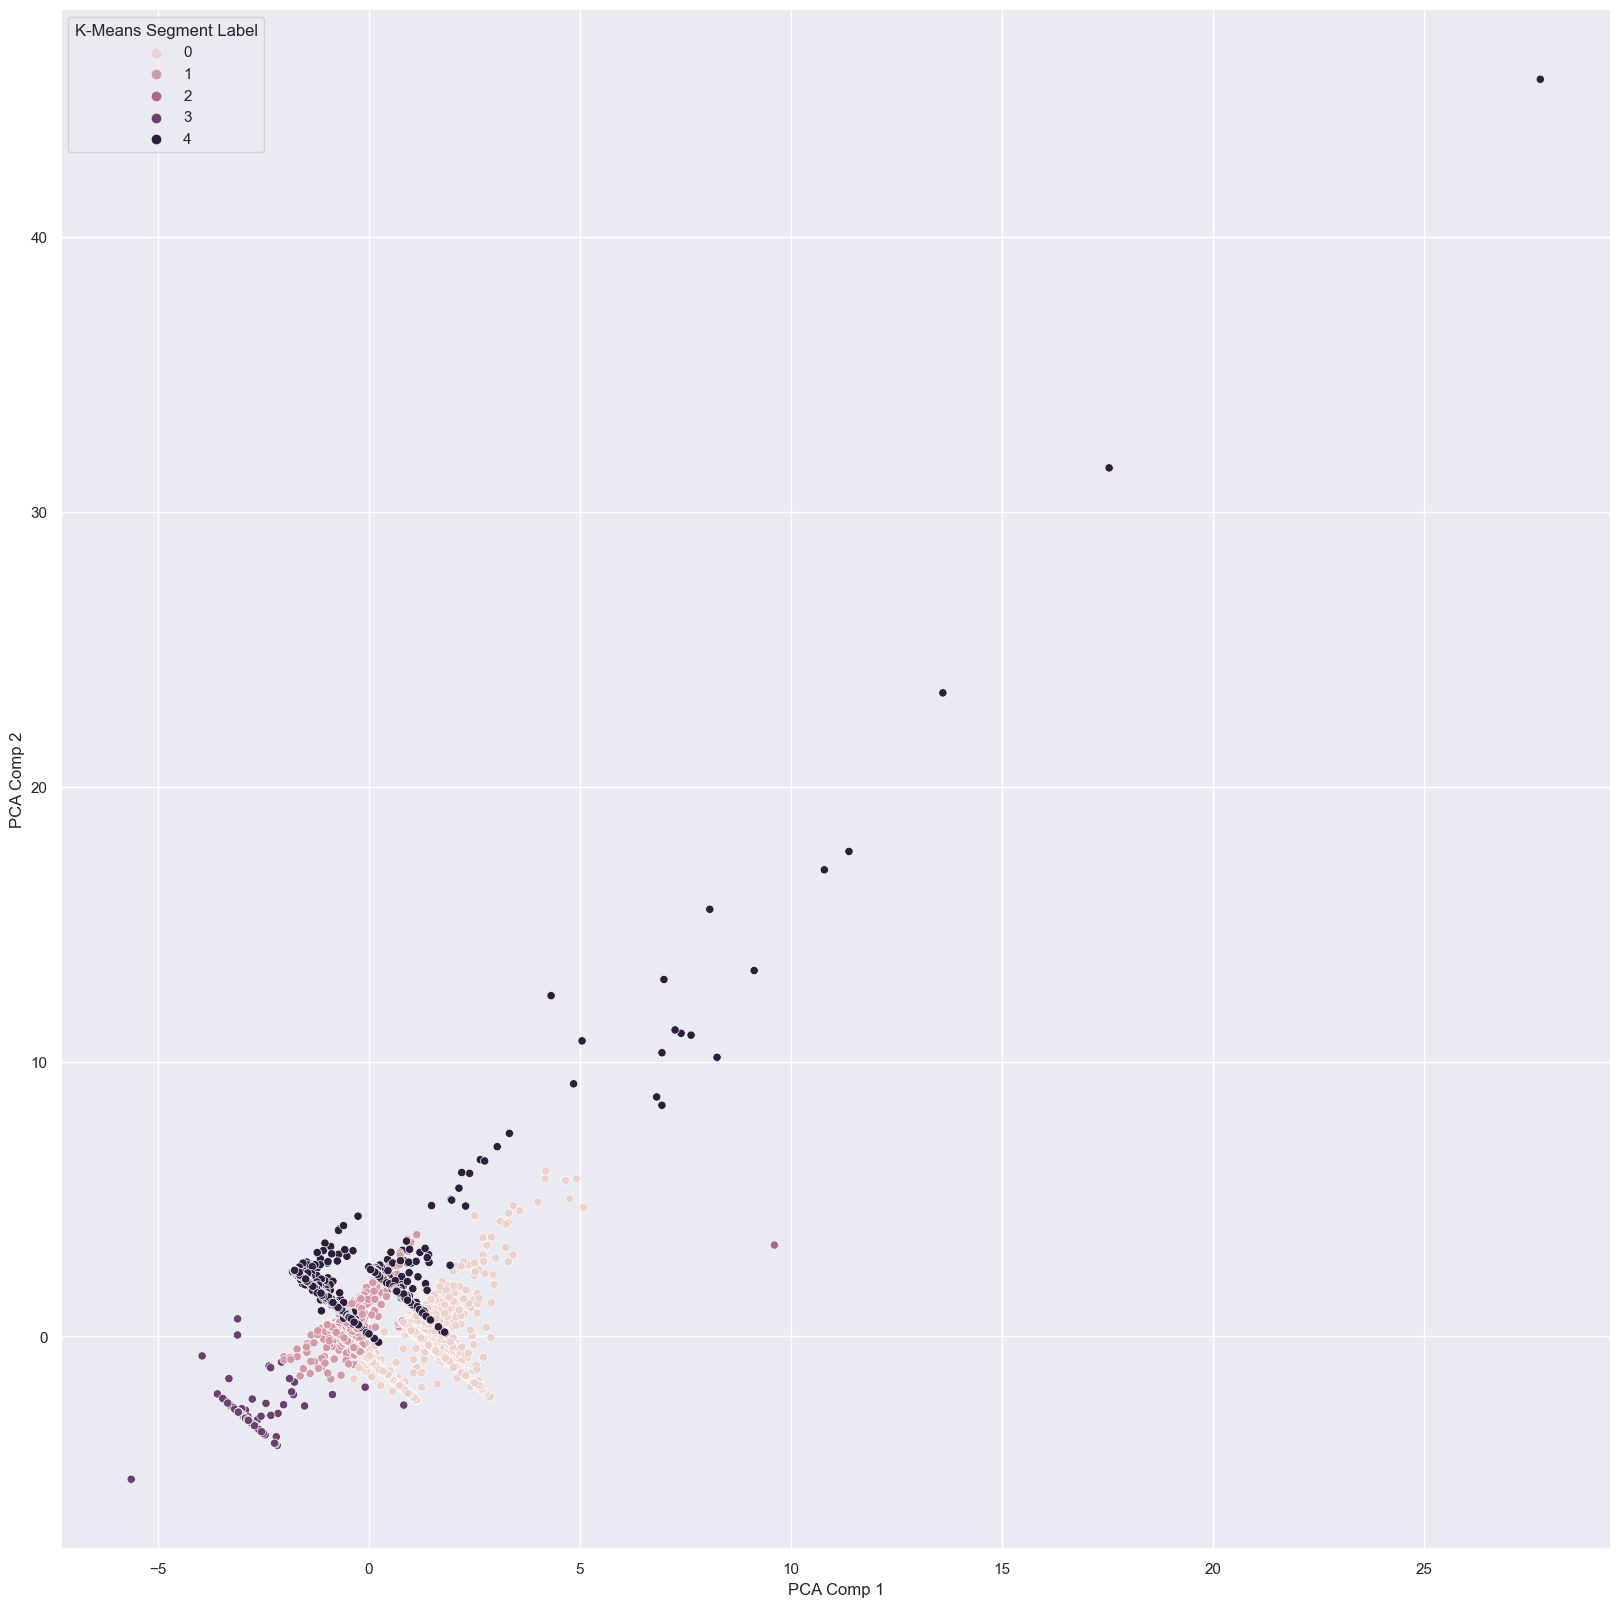

In [24]:
#Repeat for K_means N_cluster 5
#Create new data frames with PCA components and cluster segment results, then plot first two components on scatterplot.
df_kmeans_n5_SS = pd.concat([df_clean.reset_index(drop=True),pd.DataFrame(df_clean_kmeans_ss)],axis=1)
df_kmeans_n5_SS.columns.values[-5:] = ['PCA Comp 1','PCA Comp 2','PCA Comp 3','PCA Comp 4','PCA Comp 5']
df_kmeans_n5_SS['K-Means Segment Label'] = kmeans_n5_SS.labels_
scatter_df_kmeans_n5_SS = sns.scatterplot(x = df_kmeans_n5_SS['PCA Comp 1'], y = df_kmeans_n5_SS['PCA Comp 2'], 
                          hue = df_kmeans_n5_SS['K-Means Segment Label'])


scatter_df_kmeans_n5_SS

#Looks cleaner than n7

[[5.49842175e-03 3.07273733e-05 9.20000000e-01 5.08487948e-02
  1.00000000e+00 0.00000000e+00]
 [3.76743712e-03 4.60987457e-05 4.90000000e-01 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.30332960e-02 6.14701181e-05 7.10000000e-01 8.39112692e-03
  1.00000000e+00 0.00000000e+00]
 ...
 [4.48019550e-03 1.22817265e-05 9.00000000e-01 1.19531723e-06
  0.00000000e+00 0.00000000e+00]
 [1.22187150e-03 1.53560010e-05 7.00000000e-01 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.07445893e-05 2.80000000e-01 4.78126890e-06
  1.00000000e+00 0.00000000e+00]]


Text(0, 0.5, 'Cumulative Explained Variance')

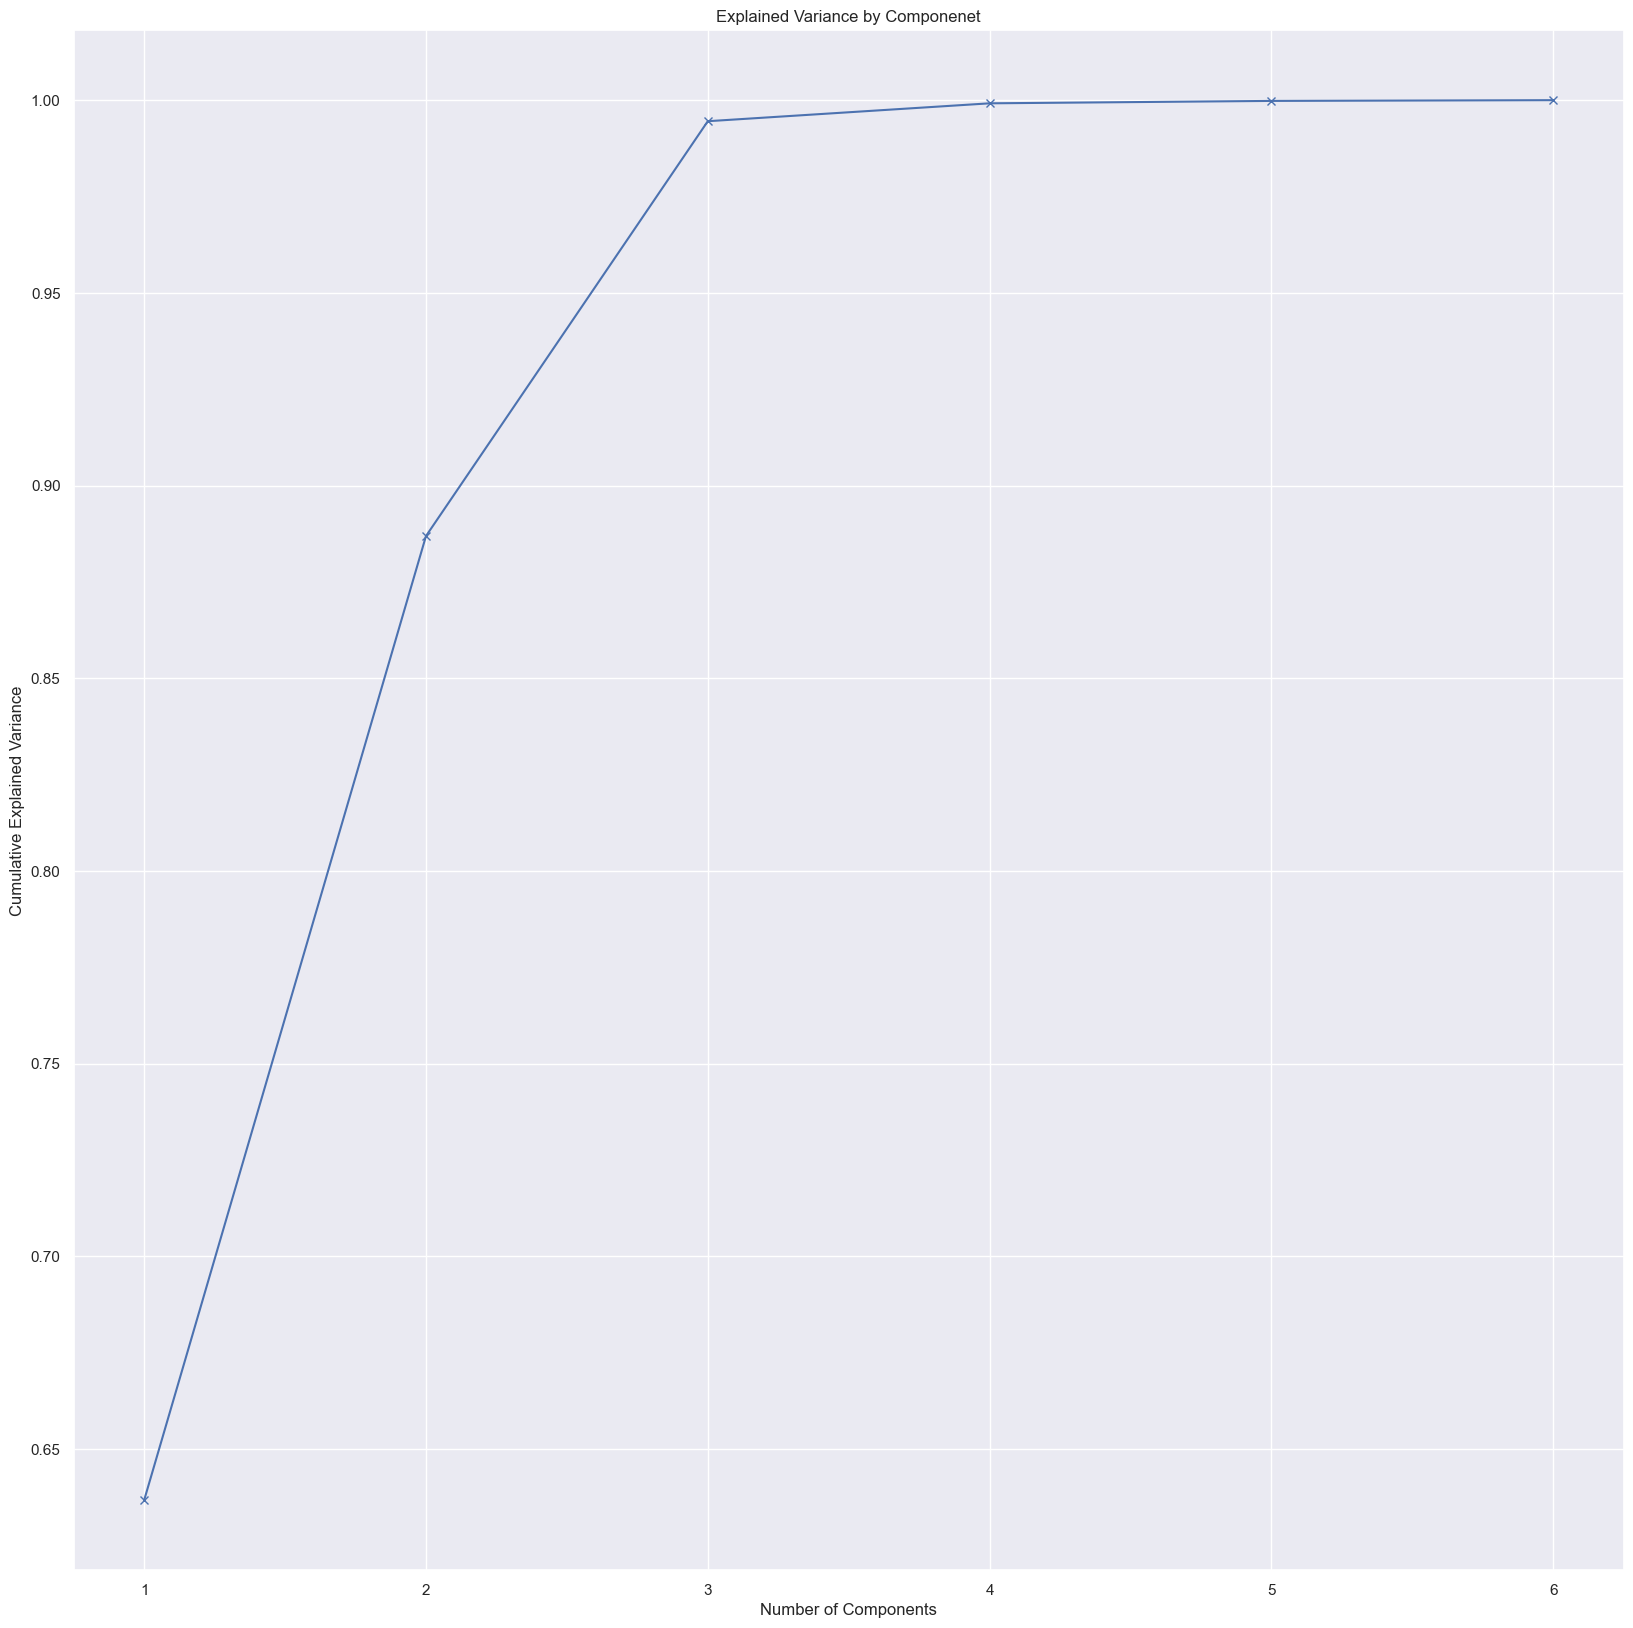

In [25]:
#Repeat Process for MinMaxScaler
#We are trying to segment data without labels. Therefore, we will be utilizing an unsupervised machine learning technique - K-means. It will be combine with the PCA method to improve the data. Two models will be compared, one using MinMaxScaler, the other usding StandarDscaler.

#preparing data for the model:
columns = ['achievements','original_price','percent_positive','num_reviews','multiplayer','mature']
df_clean_kmeans = df_clean[columns]

#2nd model - MinMaxScaler -> PCA -> K-means
scaler = MinMaxScaler()
df_clean_kmeans_MMS = scaler.fit_transform(df_clean_kmeans)
print(df_clean_kmeans_MMS)
#Initiate/fit PCA
pca = PCA()
pca.fit(df_clean_kmeans_MMS)
#Optimize PCA by visually inspecting number of componenets and cumulative explained variance.
pca.explained_variance_ratio_
#Create plot for Cumulative Explained Variance
ax =plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_.cumsum(), marker = 'x')
plt.title('Explained Variance by Componenet')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

#GOing to keep 2 components (about 87% of varianece), following the general rule of keeping around 80% variance, 6th component will overfit the model. Only 2 components needed for MinMaxScaler compared to the StandardScaler.



In [26]:
#Now that PCA is 'optimized, next is to identify N_clusters for K-means using Witihin CLuster Sum of Squares
pca = PCA(n_components=2)
df_clean_kmeans_MMS = pca.fit_transform(df_clean_kmeans_MMS)
df_clean_kmeans_MMS
wcss = []
for i in range (1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 1)
    kmeans.fit(df_clean_kmeans_MMS)
    wcss.append(kmeans.inertia_)

([<matplotlib.axis.XTick at 0x7f546cd1f4c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

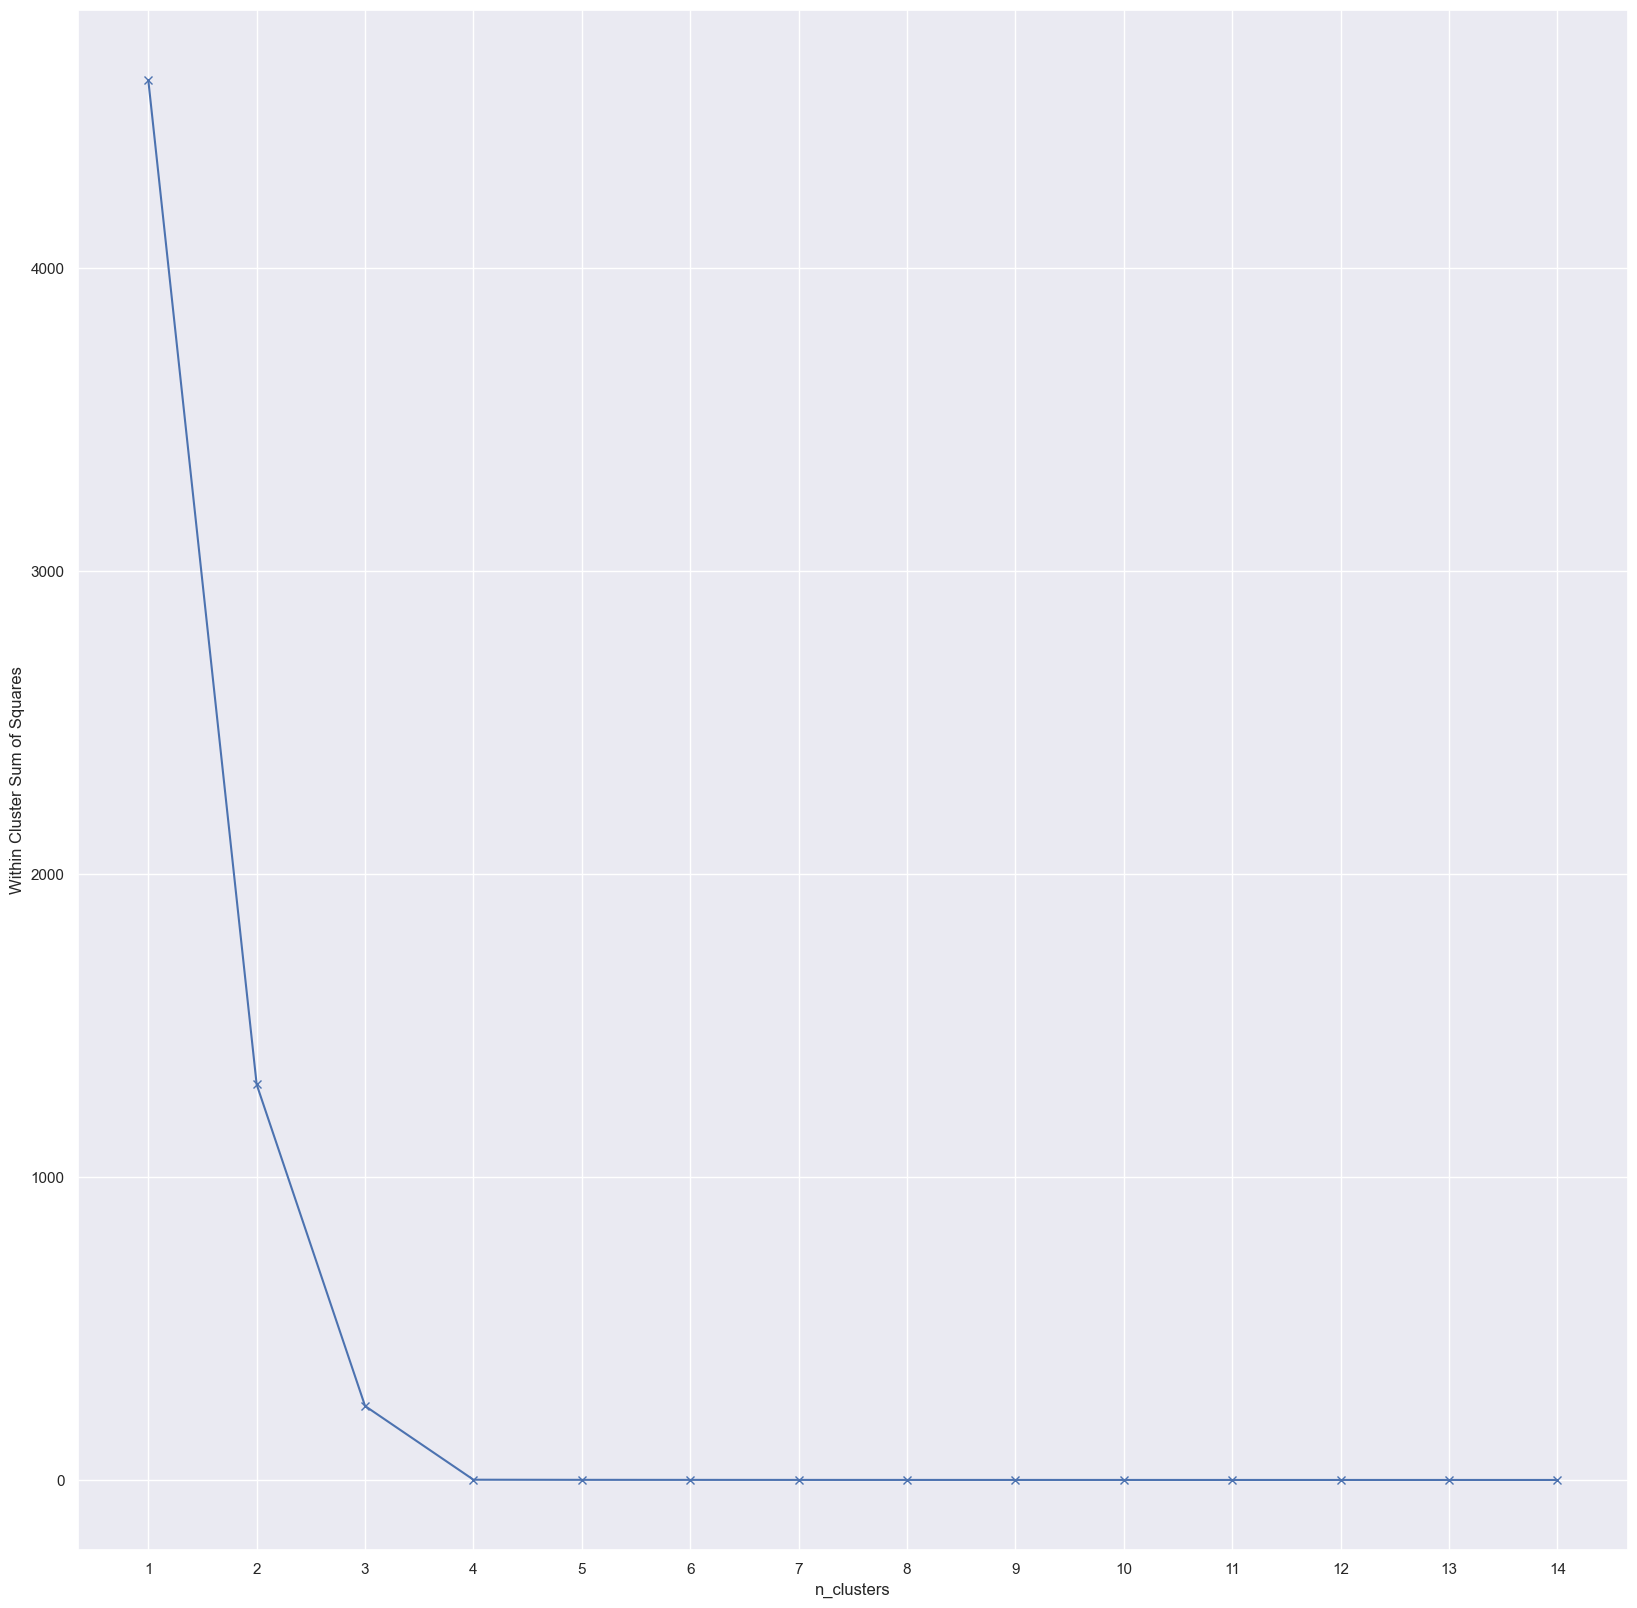

In [27]:
#Create a plot, looking for the 'elbow' effect to identify the best value for n_clusters
plt.plot(range(1,15), wcss, marker = 'x')
plt.xlabel('n_clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(1,15,1))
#Only 3 clusters seem to be optimal for the K-Means model with MinMaxScaler

<AxesSubplot:xlabel='PCA Comp 1', ylabel='PCA Comp 2'>

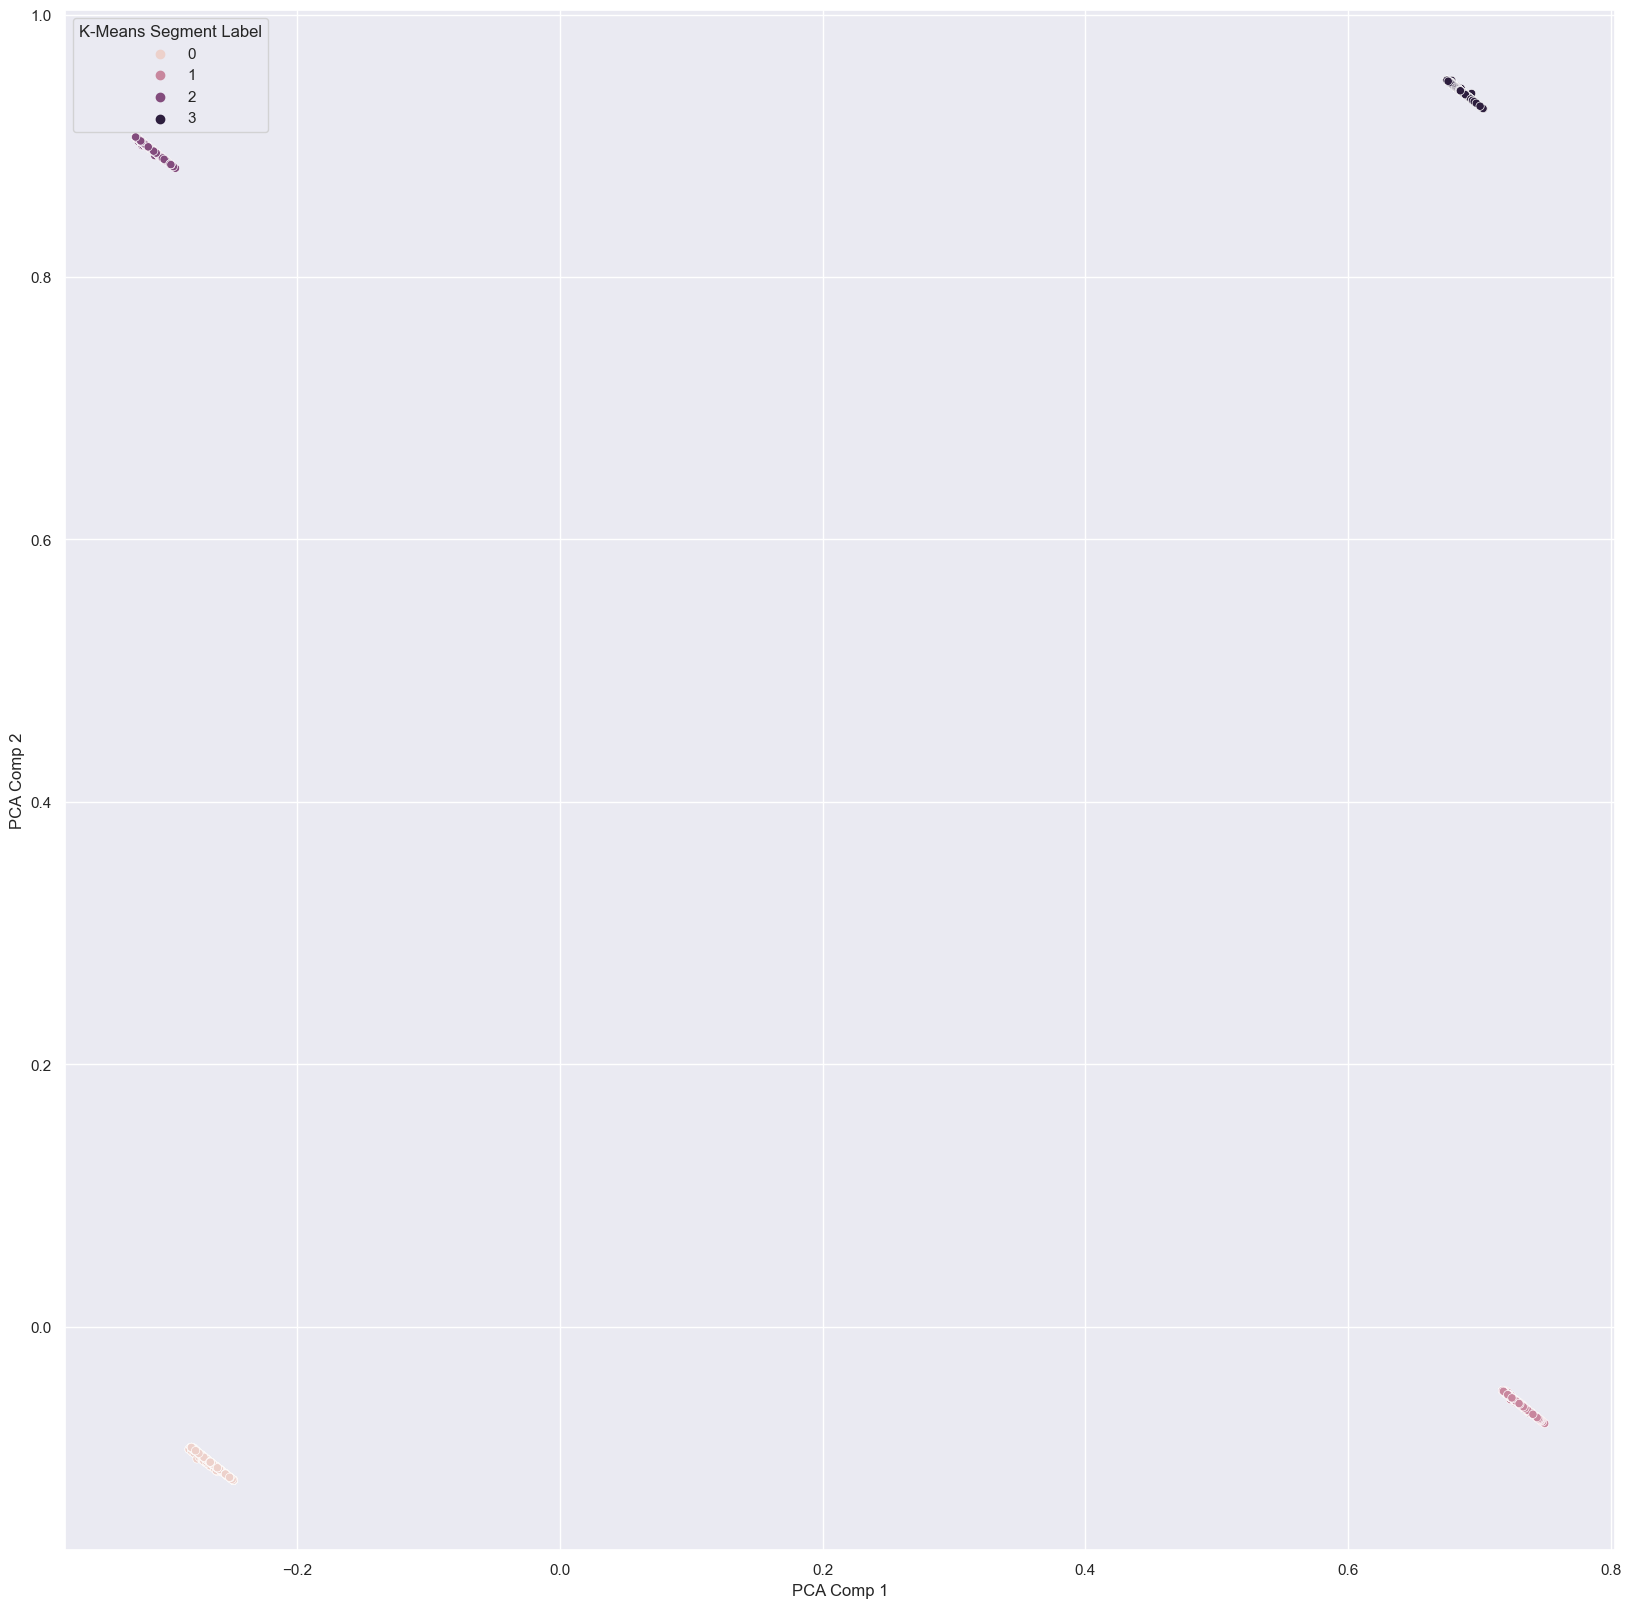

In [28]:
#3 n_cluster model with MinMaxScaler and PCA
kmeans_n3_MMS = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1)#N_clusters chosen by 'elbow' rule in chart above
kmeans_n3_MMS.fit(df_clean_kmeans_MMS)
#Create a plot
#Create new data frames with PCA components and cluster segment results, then plot the components (only 2).
df_kmeans_n3_MMS = pd.concat([df_clean.reset_index(drop=True),pd.DataFrame(df_clean_kmeans_MMS)],axis=1)
df_kmeans_n3_MMS.columns.values[-2:] = ['PCA Comp 1','PCA Comp 2']
df_kmeans_n3_MMS['K-Means Segment Label'] = kmeans_n3_MMS.labels_

scatter_df_kmeans_n3_MMS = sns.scatterplot(x = df_kmeans_n3_MMS['PCA Comp 1'], y = df_kmeans_n3_MMS['PCA Comp 2'], 
                          hue = df_kmeans_n3_MMS['K-Means Segment Label'])
scatter_df_kmeans_n3_MMS
#Extremely clean division, this model seems to be the best option. Requires less componenets, more clean cut results with only 4 segments (2 less than the maximum 5). Much more efficient.


In [29]:
for i in np.arange(0,4):
    print('K-Means Cluster Segment', i)
    for n in ['achievements','original_price','percent_positive','num_reviews','multiplayer','mature']:#columns used in dataset
        print(n,df_kmeans_n3_MMS[n][df_kmeans_n3_MMS['K-Means Segment Label']==i].unique() )

K-Means Cluster Segment 0
achievements [3.400e+01 4.100e+01 3.000e+01 1.500e+01 6.300e+01 0.000e+00 4.700e+01
 6.100e+01 3.100e+01 7.100e+01 1.200e+01 4.800e+01 6.900e+01 6.200e+01
 6.600e+01 8.000e+01 7.500e+01 5.000e+01 5.300e+01 8.900e+01 6.700e+01
 3.200e+01 4.900e+01 5.900e+01 2.400e+01 1.900e+01 2.800e+01 1.100e+01
 5.200e+01 1.390e+02 1.000e+00 5.100e+01 3.600e+01 4.300e+01 1.440e+02
 9.100e+01 5.400e+01 4.200e+01 3.300e+01 1.175e+03 5.700e+01 1.800e+01
 4.030e+02 7.000e+01 2.000e+00 7.000e+00 8.400e+01 6.000e+01 1.040e+02
 2.600e+01 1.700e+01 4.600e+01 1.300e+01 5.800e+01 3.900e+01 4.400e+01
 1.520e+02 2.200e+01 8.800e+01 3.800e+01 2.100e+01 3.500e+01 7.600e+01
 2.300e+01 4.000e+01 4.500e+01 3.700e+01 2.000e+01 9.000e+00 7.400e+01
 1.270e+02 8.500e+01 1.000e+01 2.900e+01 8.000e+00 1.200e+02 1.030e+02
 3.000e+00 7.200e+01 1.330e+02 1.400e+01 8.100e+01 1.430e+02 1.110e+02
 1.210e+02 5.500e+01 1.130e+02 9.600e+01 5.600e+01 1.746e+03 9.900e+01
 2.500e+01 1.020e+02 6.400e+01 1.600e+

In [30]:
#Narrow down the columns
for i in np.arange(0,4):
    print('K-Means Cluster Segment', i)
    for n in ['multiplayer','mature']:#columns used in dataset
        print('        ',n,df_kmeans_n3_MMS[n][df_kmeans_n3_MMS['K-Means Segment Label']==i].unique(), 									'\n','		count:',len(df_kmeans_n3_MMS[n][df_kmeans_n3_MMS['K-Means Segment Label']==i]) )
        
#Looks like the main driver for clustering decision was whether the game was multiplayer and mature
	#cluster 0 = not multiplayer and not mature
    #cluster 1 = Multiplayer and not mature
    #cluster 2 = not multiplayer and mature
    #cluster 3 = multiplayer and mature
    
#Therefore, to simplify the user experince, we should add filters for mature and multiplayer games.

K-Means Cluster Segment 0
         multiplayer [0] 
 		count: 10842
         mature [0] 
 		count: 10842
K-Means Cluster Segment 1
         multiplayer [1] 
 		count: 4267
         mature [0] 
 		count: 4267
K-Means Cluster Segment 2
         multiplayer [0] 
 		count: 1119
         mature [1] 
 		count: 1119
K-Means Cluster Segment 3
         multiplayer [1] 
 		count: 311
         mature [1] 
 		count: 311
